# **Предварительный анализ**

In [242]:
import pandas as pd
import numpy as np
import datetime as dt
import json

In [243]:
df_init = pd.read_csv('us events ad_revenue filtered 03.02-07.02.csv')
print(df_init)

         profile_id os_version device_manufacturer         device_model  \
0       JLjpGzDHBQm         11             Samsung        Galaxy Tab S6   
1       JLjpGzDHBQm         11             Samsung        Galaxy Tab S6   
2       JLkVacrzHY6         11              Google              Pixel 2   
3       JMC6wG3cX0f         10             Samsung            Galaxy S9   
4       JLzWWTJfi1b         10             Samsung            Galaxy S9   
...             ...        ...                 ...                  ...   
860074  JLSQY2nx1NQ         12             Samsung  Galaxy S21 Ultra 5G   
860075  JLKWwju79CA         12             Samsung             SM-G991U   
860076  JLKWwju79CA         12             Samsung             SM-G991U   
860077  JLKWwju79CA         12             Samsung             SM-G991U   
860078  JLKWwju79CA         12             Samsung             SM-G991U   

       device_type device_locale    event_name  \
0           tablet         en_US  c_ad_revenue   

In [244]:
# вытащим поля json в отдельный датафрейм

event = df_init['event_json'].apply(json.loads).values.tolist()
df_event = pd.DataFrame.from_records(event)


Для проведения требуемого анализа нам понадобятся только столбцы, индентифицирующие пользователя, время показа рекламы, версия ОС, тип рекламы и доход от конкретного показа.
Составим датафрейм, который бы содержал эту информацию, предварительно проанализируем датафрейм и преобразуем некоторые данные.

In [245]:
df = df_init[['profile_id', 'event_datetime', 'os_version', 'city']].merge(df_event[['ad_type', 'revenue']],
                                                                           left_index=True, right_index=True)
df['event_datetime'] = pd.to_datetime(df['event_datetime'], format='%Y-%m-%d %H:%M:%S').dt.hour.astype('int')
adv = ['banner', 'int', 'rv']

# сразу переведем revenue в eCPM
df['eCPM'] = df['revenue'].mul(1000)
df = df.drop('revenue', axis=1)

# какой тип рекламы в среднем прибыльнее?
df_adv = df[['ad_type', 'eCPM']].groupby(by='ad_type', as_index=False).mean()
print(df_adv)


  ad_type       eCPM
0  banner   0.744113
1     int  36.209634
2      rv  65.051165


In [246]:
# процент логов, содержащих информацию о городе пользователя
print(round(df.notna().sum()['city'] / len(df) * 100, 2), '% логов содержат информацию о городе пользователя')

62.36 % логов содержат информацию о городе пользователя


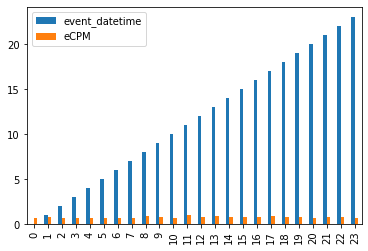

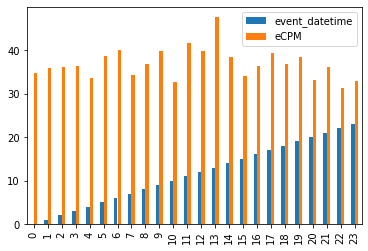

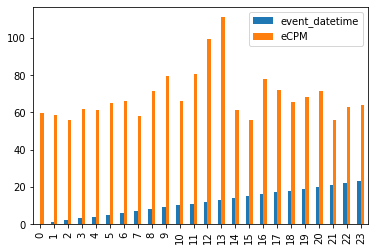

In [247]:
# посмотрим, влияет ли время суток на eCPM
for i in adv:
    df_time = df[df.ad_type == i][['event_datetime', 'eCPM']].groupby(by='event_datetime',
                                                                      as_index=False).mean().plot.bar()

Видимых зависимостей конкретно eCPM от времени суток нет. Но наверняка есть время суток, в которое пользователи наиболее активны. Тогда для вышепостроенных диаграмм эта разница может нивелироваться разбросом стоимости рекламы, то есть если в наиболее активное время показывается реклама с наименьшим доходом, а в более спокойное время показывается реклама с наибольшим доходом.
Поэтому имеет смысл скорректировать время показа рекламы в зависимости от времени суток. Проверим активность пользователей в разные часы.



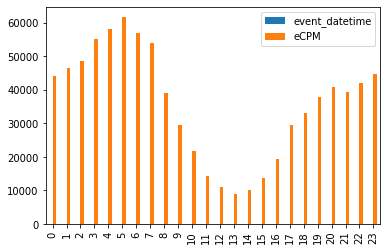

In [248]:
df_time = df[['event_datetime', 'eCPM']].groupby(by='event_datetime', as_index=False).count().plot.bar()

Видим, что наименее активное время 11-15 часов. К вечеру активность возрастает и достигает максимума к 5 часам утра.

Проверим города на количество просмотров рекламы не имеет смысла, так как оно должно коррелировать с населением города. Зато можно проверить, с каких версий ОС чаще всего смотрят рекламу.

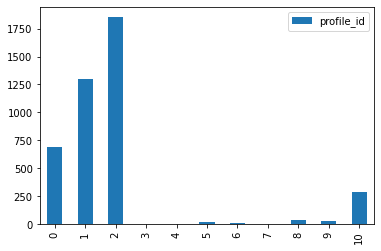

In [249]:
df_time = df[['profile_id','os_version']].groupby(by='os_version', as_index=False).nunique().plot.bar()

Получается, что большинство юзеоров пользуются устройствами с ОС версии 0, 1, 2.

# **Распределение средних eCPM-ов юзеров**

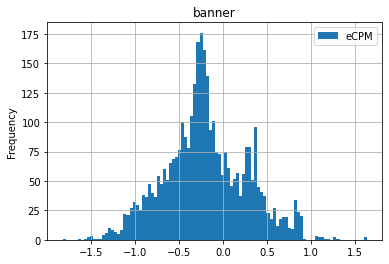

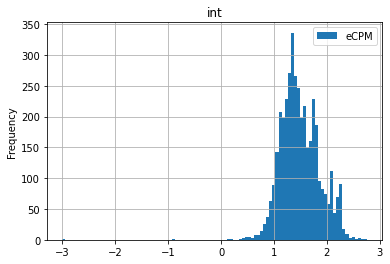

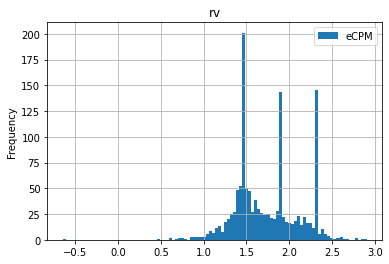

In [250]:
df_users = df[['profile_id', 'ad_type', 'eCPM']]

for i in adv:
    x = df_users[df_users.ad_type == i][['eCPM', 'profile_id']].groupby(by='profile_id', as_index=False).mean()
    x['eCPM'] = np.log10(x['eCPM'].add(0.001))
    x.plot.hist(bins=100, title=i, grid=True)

Данные eCPM сильно скошены влево, поэтому имеет смысл прологарифмировать значения. Можно сделать выводы, что для типов реклам banner и int полученное распределение близко к логнормальному (нет мультимодальности, ярко выраженной ассиметрии, присутствуют единичные выбросы, которые соит рассматривать отдельно). Для типа рекламы rv имеется значительное количество выбросов, мултимодальность, сильное отклонение от куполообразности.

# **Средние eCPM-ы по городам и ОС**

Cредние eCPM-ы по городам:

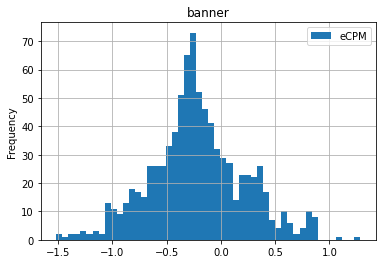

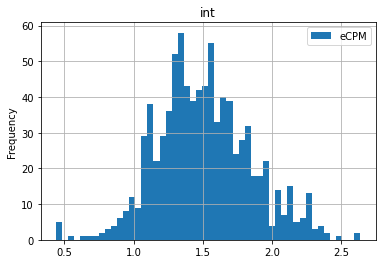

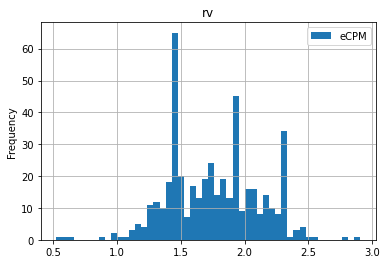

In [251]:
df_city = df[['ad_type', 'eCPM', 'city']]

for i in adv:
    x = df_city[df_city['city'].notna()]
    x = df_city[df_city.ad_type == i][['eCPM', 'city']].groupby(by='city', as_index=False).mean()
    x['eCPM'] = np.log10(x['eCPM'].add(0.001))
    x.plot.hist(bins=50, title=i, grid=True)

На гистограммах выше приведены графики прологарифмированных средних значений eCPM по городам. Гистограммы по форме очень напонимают графики распределения, построенные для усредненных значений eCPM по пользователям. Это вероятно наблюдается, так как город определяется пользователем. Посмотрим ниже на города, которые оказались явно выбросами. Возьмем 10 начальных и 5 конечных значений.

In [252]:
print('Следующие города являются выбросами:')
print()
for i in adv:
    x = df_city[df_city['city'].notna()]
    x = df_city[df_city.ad_type == i][['eCPM', 'city']].groupby(by='city', as_index=False).mean().sort_values(by='eCPM',
                                                                                                              ascending=False)
    print(i)
    print('max: ', ', '.join(x['city'].head(10).values.tolist()))
    print('min: ', ', '.join(x['city'].tail(5).values.tolist()))
    print()


Следующие города являются выбросами:

banner
max:  La Crosse, Mountain View, Huron, Lawrenceville, Oxnard, Colchester, Corbin, Clarks Summit, Dobson, Muncie
min:  Bell Gardens, Vista, Malden, Anderson, Canonsburg

int
max:  Madisonville, La Crosse, Rohnert Park, Nashua, Norwood, Spirit Lake, Rocky Mount, Oxnard, Lake Worth, Fredericksburg
min:  Fort Walton Beach, Ocala, Kailua-Kona, Chantilly, Lincoln City

rv
max:  East Peoria, Norwood, Idaho Falls, Valparaiso, Rocky Mount, Hilliard, Glen Burnie, Mayfield, El Paso, Port Huron
min:  Uniontown, Bethlehem, Oak Creek, Fort Walton Beach, Utica



Cредние eCPM-ы по типам ОС:

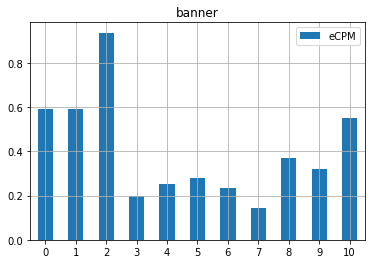

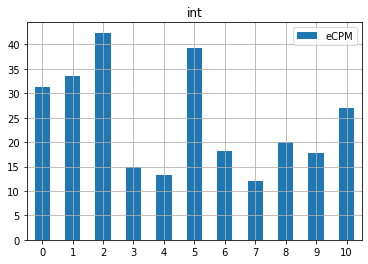

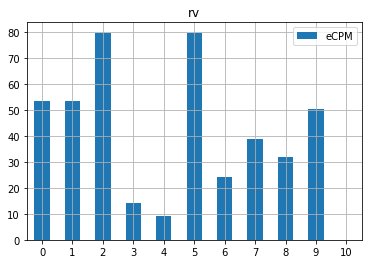

In [253]:
df_city = df[['ad_type', 'eCPM', 'os_version']]

for i in adv:
    x = df_city[df_city.ad_type == i][['eCPM', 'os_version']].groupby(by='os_version',
                                                                      as_index=False).mean()\
                                                                      .sort_values(by='os_version')
    if i == 'rv':
        x = x.append({'eCPM': 0, 'os_version': 10}, ignore_index=True)
    x.plot.bar(title=i, grid=True, rot=0)


По приведенным выше диграмам можно сделать выводы, что наиболее высокий средний eCPM для любого типа рекламы наблюдается у версий ОС: 0, 1, 2, для banner так же у версии 10, для int так же у версий 5, 10, для rv так же у версий 5, 9.

# **Максимальные eCPM-ы по городам и ОС**

Максимальные eCPM-ы по городам:

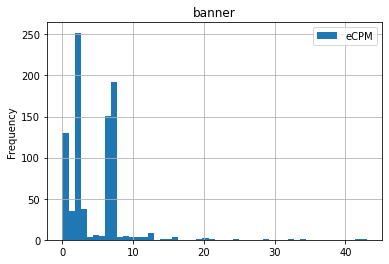

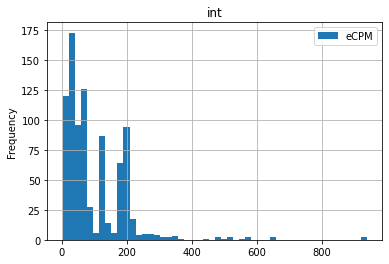

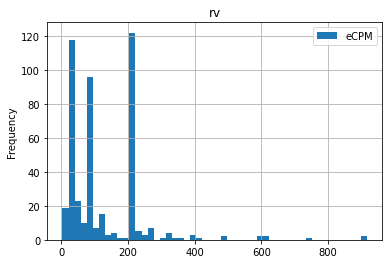

In [254]:
df_city = df[['ad_type', 'eCPM', 'city']]

for i in adv:
    x = df_city[df_city['city'].notna()]
    x = df_city[df_city.ad_type == i][['eCPM', 'city']].groupby(by='city', as_index=False).max().sort_values(by='eCPM',
                                                                                                             ascending=False)
    x.plot.hist(bins=50, title=i, grid=True)

Гистограммы имеется выраженная мультимодальность и наличие значительных выбросов. Вероятно, мультимодальность должна хорошо обяъясняться кластеризацией. 


In [255]:
print('Следующие города являются выбросами:')
print()
for i in adv:
    x = df_city[df_city['city'].notna()]
    x = df_city[df_city.ad_type == i][['eCPM', 'city']].groupby(by='city', as_index=False).max().sort_values(by='eCPM',
                                                                                                             ascending=False)
    print(i)
    print(', '.join(x['city'].head(20).values.tolist()))
    print()


Следующие города являются выбросами:

banner
Pittsburgh, Duluth, Corbin, Jersey City, Santa Rosa, Detroit, La Crosse, Laurel, Gainesville, Bradenton, Hillsboro, East Peoria, Dayton, Nashua, Omaha, Mountain View, Minneapolis, Idaho Falls, Indianapolis, Scranton

int
San Antonio, Milwaukee, La Crosse, Madisonville, East Peoria, Cleveland, Miami, Nashua, Indianapolis, Richardson, Rocky Mount, York, Gainesville, Cincinnati, Hagerstown, Los Angeles, Phoenix, Memphis, Rohnert Park, New York

rv
East Peoria, Lee's Summit, Indianapolis, Cincinnati, Rocky Mount, Columbus, Norwood, Cleveland, Hilliard, Washington, Nashville, San Francisco, Pittsburgh, Idaho Falls, Port Huron, Statesville, Valparaiso, Charlotte, Minneapolis, New York



Максимальные eCPM-ы по ОС:

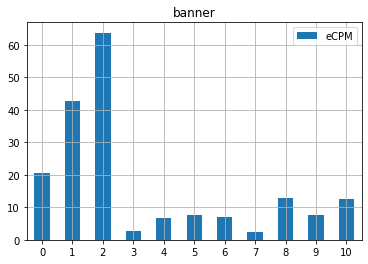

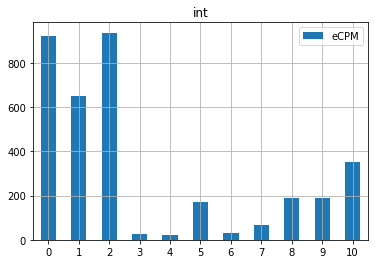

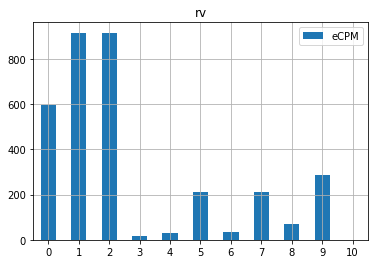

In [256]:
df_city = df[['ad_type', 'eCPM', 'os_version']]

for i in adv:
    x = df_city[df_city.ad_type == i][['eCPM', 'os_version']].groupby(by='os_version',
                                                                      as_index=False).max()\
                                                                      .sort_values(by='os_version')
    if i == 'rv':
        x = x.append({'eCPM': 0, 'os_version': 10}, ignore_index=True)
    x.plot.bar(title=i, grid=True, rot=0)


Максимальные значения eCPM-ов по ОС на порядок превышают средние значения eCPM-ов по ОС. Это означает, что для анализа eCPM по ОС лучше отказаться от среднего значения и пользоваться медианой.

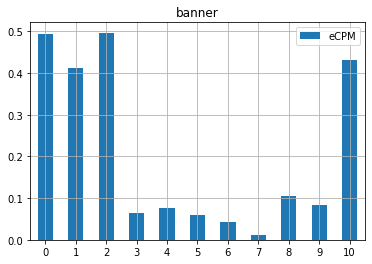

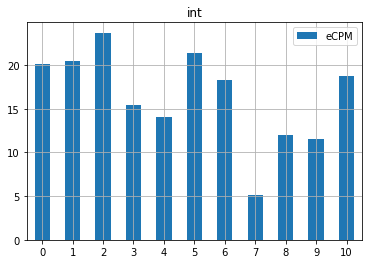

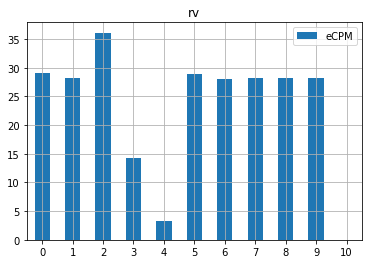

In [257]:
df_city = df[['ad_type', 'eCPM', 'os_version']]

for i in adv:
    x = df_city[df_city.ad_type == i][['eCPM', 'os_version']].groupby(by='os_version',
                                                                      as_index=False).median()\
                                                                      .sort_values(by='os_version')
    if i == 'rv':
        x = x.append({'eCPM': 0, 'os_version': 10}, ignore_index=True)
    x.plot.bar(title=i, grid=True, rot=0)


По медианным значениям eCPM можно сделать следующие выводы:
наиболее высокий медианный eCPM для banner: 0, 1, 2, 10
минимальный медианный eCPM для init: 7
минимальные медианные eCPM для rv: 3, 4,1 0.

# **Выводы**



1.  Пользователи наиболее активны в вечернее и ночное время. Пик активности - 5 часов утра. Эта закономерность не наблюдается для средних eCPM по часам. Значит, можно увеличить доход, показывая более высокую по стоимости рекламу в наиболее активные часы.

1.   Самый высокий средний доход от типа рекламы rv и самый низкий от banner. Стоит провести компанию по продвижению просмотров rv. Возможно, временно давать повышенное количество ресурсов за просмотр видео.

1.   Юзеры с версиями ОС 1, 2Б 3 в общем наиболее активно смотрят рекламу.

1.   Рапсределения eCPM для типов реклам banner и int логнормальные, для типа rv - мультимодальное.

1.   Среди средних и максимальных eCPM по городам явно присутсвуют города-выбросы, как в большую, так и в меньшую сторону. Стоит разобраться почему.

1.   По максимальным значениям eCPM по городам можно удачно провести кластеризацию. И найти общее для городов в кластерах.

2.   Среди средних и максимальных eCPM по ОС наблюдается различие на порядок, лучше использовать медиану.
